<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/TrainNVP_and_measure_Reconstruction_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
 
plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

In [32]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [33]:
sys.path.append('../')
from vae.model import get_prior, get_posterior, get_likelihood

In [34]:
import vae.create_datasets as crd

In [37]:
likelihood  = 'Gauss'
class_label = -1
network_type= 'fully_connected'
data_set    = 'fmnist'
latent_size = 4
AE          = False

In [40]:
if AE:
    params = pickle.load(open('../params/params_%s_%s_%d_%d_%s-AE.pkl'%(data_set,likelihood,class_label,latent_size, network_type),'rb'))
else:
    params = pickle.load(open('../params/params_%s_%s_%d_%d_%s.pkl'%(data_set,likelihood,class_label,latent_size,network_type),'rb'))
module_dir = params['module_dir']
model_dir  = params['model_dir']

In [41]:
all_subdirs   = [os.path.join(module_dir,d) for d in os.listdir(module_dir+'/') if os.path.isdir(os.path.join(module_dir,d))]
latest_subdir = max(all_subdirs, key=os.path.getmtime)

In [42]:
generator_path   = os.path.join(latest_subdir,'decoder')
encoder_path     = os.path.join(latest_subdir,'encoder')

In [43]:
nvp_depth = 4
indices   = np.arange(params['latent_size'])
permutations = [np.random.permutation(indices) for ii in range(nvp_depth)]

In [44]:
train_input_fn, eval_input_fn = crd.build_input_fns(params['data_dir'],params['data_set'], 32,label=params['class_label'],flatten=True)
train_input_fn_full, eval_input_fn_full = crd.build_input_fns(params['data_dir'],params['data_set'],10000,label=params['class_label'],flatten=True)

loading fmnist dataset


FileNotFoundError: [Errno 2] No such file or directory: './data/fashion/train-labels-idx1-ubyte.gz'

In [14]:
tf.reset_default_graph()


lr            = tf.placeholder_with_default(0.001,shape=[])
sigma         = tf.placeholder_with_default(0.1,shape=[])
sample_size   = tf.placeholder_with_default(16,shape=[])
data          = train_input_fn()
data_long     = train_input_fn_full()
encoder       = hub.Module(encoder_path, trainable=False)
generator     = hub.Module(generator_path, trainable=False)
optimizer     = tf.train.AdamOptimizer(learning_rate=lr)

encoded_long,_= tf.split(encoder({'x':data_long},as_dict=True)['z'], 2, axis=-1)
prior         = get_prior(params['latent_size'])
posterior     = get_posterior(encoder)
likelihood    = get_likelihood(generator,params['likelihood'],sigma)

# inspect the model
z     = posterior(data).mean()
prior_sample = prior.sample(sample_size)
x     = likelihood(prior_sample).mean()
recon = likelihood(z).mean()



### ----------- NVP ----------- ###
def init_once(x, name):
    return tf.get_variable(name, initializer=x, trainable=False)


nvp_size      = [[512, 512] for ii in range(nvp_depth)]


def get_nvp():
    base_dis = get_prior(params['latent_size'])
    chain    = []
  
    perms         = [tfb.Permute(permutation=init_once(permutations[ii],name="permutation%d"%ii)) for ii in range(nvp_depth)]
  
    for i,s in enumerate(nvp_size):
        if i==0:
            chain.append(perms[i])
        if i>2:
            chain.append(tfb.RealNVP(num_masked=params['latent_size']//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i, shift_only=True)))
        else:
            chain.append(tfb.RealNVP(num_masked=params['latent_size']//2,shift_and_log_scale_fn=tfb.real_nvp_default_template(hidden_layers=s,name='nvp%d'%i)))
    chain.append(perms[i])

    nvp = tfd.TransformedDistribution(distribution=base_dis,bijector=tfb.Chain(chain),name='mynvp')
                 
    return nvp

def nvp_module_spec():
    z_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    sample_size  = tf.placeholder(tf.int32, shape=[])
    u_sample     = tf.placeholder(tf.float32, shape=[None,params['latent_size']])
    nvp_         = get_nvp()
    log_prob     = nvp_.log_prob(z_sample)
    nvp_sample   = nvp_.sample(sample_size)
    nvp_fwd_pass = nvp_.bijector.forward(u_sample)
    hub.add_signature(inputs={'z_sample':z_sample,'sample_size':sample_size, 'u_sample':u_sample},outputs={'log_prob':log_prob, 'sample':nvp_sample, 'fwd_pass': nvp_fwd_pass})

nvp_spec  = hub.create_module_spec(nvp_module_spec)
nvp_funcs = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

loss      = -tf.reduce_mean(nvp_funcs({'z_sample':z,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['log_prob'])

opt_op_nvp = optimizer.minimize(loss)

nvp_sample = nvp_funcs({'z_sample':np.zeros((1,params['latent_size'])),'sample_size':1, 'u_sample':prior_sample}, as_dict=True)['fwd_pass']
x_new      = likelihood(nvp_sample).mean()

# # ---------------------------end train nvp ----------------- #

# #comment train nvp above section above and uncomment this for loading the trained module

# #nvp_funcs     = hub.Module(nvp_func_path, trainable=False)

W1029 16:43:11.550108 140521237747520 deprecation.py:323] From ../vae/create_datasets.py:68: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
W1029 16:43:11.790931 140521237747520 deprecation_wrapper.py:119] From ../vae/model.py:78: The name tf.variable_scope is deprecated

mean Tensor("module_1_apply_default/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)
mean Tensor("module_1_apply_default_1/model/decoder/dense_4/BiasAdd:0", shape=(32, 784), dtype=float32)


W1029 16:43:12.668040 140521237747520 deprecation.py:323] From /home/nessa/miniconda3/envs/tflow/lib/python3.7/site-packages/tensorflow_hub/saved_model_lib.py:110: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


mean Tensor("module_1_apply_default_2/model/decoder/dense_4/BiasAdd:0", shape=(?, 784), dtype=float32)


In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [16]:
rec, d = sess.run([recon,data])

In [17]:
x_sample = sess.run(x)

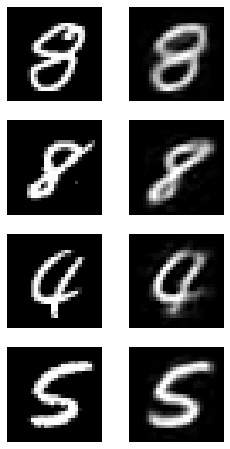

In [18]:
jj=1
plt.figure(figsize=(2*2,4*2))
for ii in range(4):
    plt.subplot(4,2,jj)
    plt.imshow(d[ii].reshape(28,28),cmap='gray')
    plt.axis('off')
    jj+=1
    plt.subplot(4,2,jj)
    plt.imshow(rec[ii].reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
    jj+=1


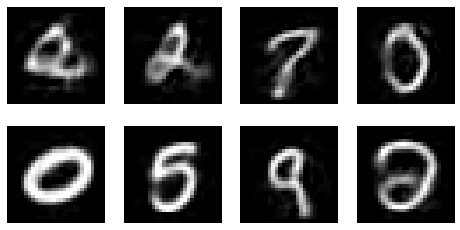

In [19]:
jj=1
plt.figure(figsize=(4*2,2*2))
for ii in range(8):
    plt.subplot(2,4,jj)
    plt.imshow(x_sample[ii].reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
    jj+=1

In [20]:
z_sample = sess.run(encoded_long)

W1029 16:43:16.658094 140521237747520 font_manager.py:1282] findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


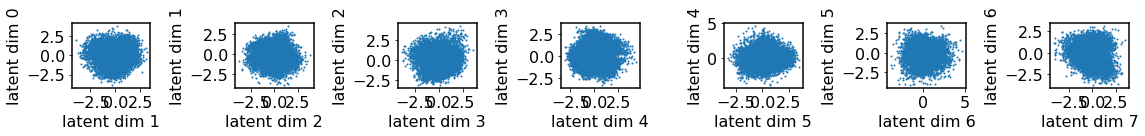

In [21]:
plt.figure(figsize=((latent_size-1)*2+2,2))
for nn in range(latent_size-1):
    plt.subplot(1,latent_size-1,nn+1)
    plt.scatter(z_sample[:,nn],z_sample[:,nn+1],s=1) 
    plt.ylabel('latent dim %d'%nn)
    plt.xlabel('latent dim %d'%(nn+1))
    plt.tight_layout()

**Training of the NVP**

In [22]:
nvp_loss = []

In [57]:
ii     = 0
nepoch = 0
learning_rate = 1e-4

#train the nvp
while nepoch<1000:
    _, ll = sess.run([opt_op_nvp,loss],  feed_dict={lr: learning_rate})
    nvp_loss+=[ll]
    if ii%1000==0:
        print(np.mean(nvp_loss[-50::]))
    ii+=1

11.218714
11.079425
11.085453
11.154743
11.120686
11.036766
11.130027
11.0650625
11.097338
11.152729
11.220211


KeyboardInterrupt: 

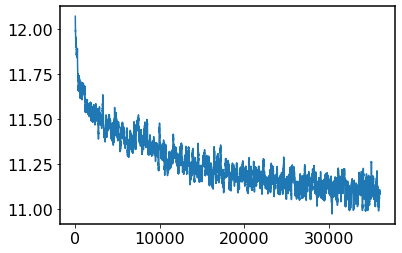

In [58]:
plt.figure()
plt.plot(np.convolve(nvp_loss[::],np.ones((100))/100., mode='valid'),label='nvp loss')

In [77]:
s_nvp       = sess.run(x_new)
s           = sess.run(x)
z_sample_nvp = sess.run(nvp_sample,feed_dict={sample_size:10000})

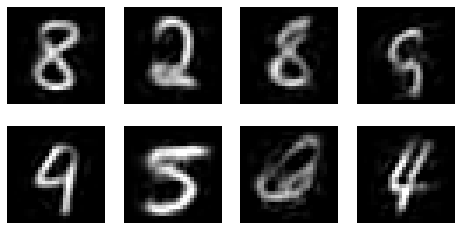

In [78]:
jj=1
plt.figure(figsize=(4*2,2*2))
for ii in range(8):
    plt.subplot(2,4,jj)
    plt.imshow(s_nvp[ii].reshape(28,28),cmap='gray',vmin=0, vmax=1)
    plt.axis('off')
    jj+=1

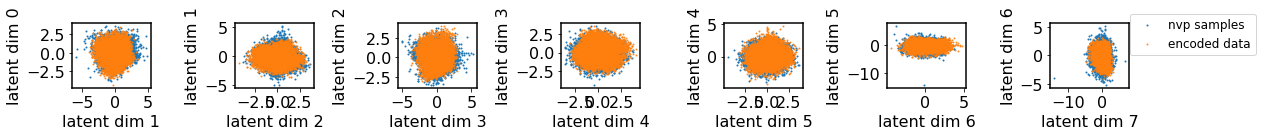

In [79]:
plt.figure(figsize=((latent_size-1)*2+2,2))
for nn in range(latent_size-1):
    plt.subplot(1,latent_size-1,nn+1)
    plt.scatter(z_sample_nvp[:,nn],z_sample_nvp[:,nn+1],s=1, label='nvp samples') 
    plt.scatter(z_sample[:,nn],z_sample[:,nn+1],s=1,alpha=0.8, label='encoded data') 
    plt.ylabel('latent dim %d'%nn)
    plt.xlabel('latent dim %d'%(nn+1))
    plt.tight_layout()
plt.legend(loc=(1.01,0.5))

In [91]:
nvp_dir          = os.path.join(params['module_dir'],'nvp')
if not os.path.isdir(nvp_dir):
    os.makedirs(nvp_dir)
nvp_funcs.export(nvp_dir,sess)